In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from keras import layers, models
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from keras.applications import ResNet50V2
import seaborn as sns

### Helper functions

In [ ]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
def evaluate(test_set, model):
    loss, accuracy = model.evaluate(test_set)
    y_true = []
    y_pred = []

    for images, labels in test_set:
        preds = model.predict(images, verbose=0)
        preds = np.argmax(preds, axis=1)
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    print(classification_report(y_true, y_pred, target_names=test_set.class_names))
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Greens',
                xticklabels=test_set.class_names,
                yticklabels=test_set.class_names)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.yticks(rotation=0)
    plt.title(f'Normalized Confusion Matrix\nLoss: {loss:.4f}, Accuracy: {accuracy*100:.2f}%')
    plt.tight_layout()
    plt.show()

def show_predictions(model, test_set, num_images=9):
    plt.figure(figsize=(8, 8))
    count = 0

    for images, labels in test_set:
        preds = model.predict(images, verbose=0)
        pred_labels = np.argmax(preds, axis=1)

        for i in range(images.shape[0]):
            if count >= num_images:
                break

            true_label = labels[i].numpy()
            pred_label = pred_labels[i]

            color = 'green' if pred_label == true_label else 'red'
            title = f"True: {test_set.class_names[true_label]}\nPred: {test_set.class_names[pred_label]}"

            plt.subplot(int(np.sqrt(num_images)), int(np.ceil(num_images / np.sqrt(num_images))), count + 1)
            plt.imshow(images[i]/255)
            plt.title(title, color=color, fontsize=10)
            plt.axis('off')

            count += 1

        if count >= num_images:
            break

    plt.tight_layout()
    plt.show()


### Global parameters

In [3]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
SEED = 65
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Loading dataset

In [4]:
train_set = image_dataset_from_directory('PLD_3_Classes_256/Training', image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, seed=SEED)
val_set = image_dataset_from_directory('PLD_3_Classes_256/Validation', image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, seed=SEED)
test_set = image_dataset_from_directory('PLD_3_Classes_256/Testing', image_size=IMAGE_SIZE, batch_size=BATCH_SIZE, seed=SEED)

Found 3251 files belonging to 3 classes.
Found 416 files belonging to 3 classes.
Found 405 files belonging to 3 classes.


### Class distribution

In [5]:
class_names = train_set.class_names
all_labels = []
for images, labels in train_set:
    all_labels.extend(labels.numpy())
    
label_counts = Counter(all_labels)

for label_index, count in label_counts.items():
    print(f"{class_names[label_index]}: {count}")

Late_Blight: 1132
Healthy: 816
Early_Blight: 1303


### Visualizing samples

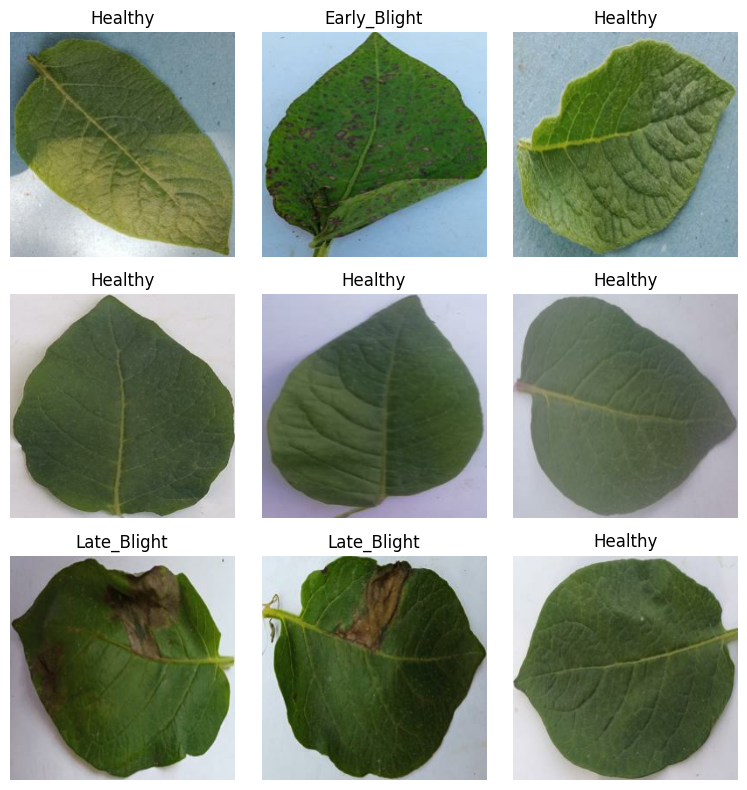

In [6]:
plt.figure(figsize=(8,8))
class_names = train_set.class_names
for images, labels in train_set.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i]/255)
        plt.title(class_names[labels[i]])
        plt.axis('off')
        plt.tight_layout()
        
plt.show()

## `1` Using a model built from scratch

### Model building

In [7]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    data_augmentation,

    layers.Rescaling(1./255),

    layers.Conv2D(32, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),

    layers.Dense(512),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                    

### Model training

In [8]:
np.random.seed(SEED)
tf.random.set_seed(SEED)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_set,validation_data=val_set,epochs=50, callbacks=[early_stop])

Epoch 1/50
102/102 [==============================] - 13s 97ms/step - loss: 0.9615 - accuracy: 0.6478 - val_loss: 3.9582 - val_accuracy: 0.2452
Epoch 2/50
102/102 [==============================] - 9s 90ms/step - loss: 0.6207 - accuracy: 0.7613 - val_loss: 4.7674 - val_accuracy: 0.2452
Epoch 3/50
102/102 [==============================] - 9s 92ms/step - loss: 0.5009 - accuracy: 0.8059 - val_loss: 1.6850 - val_accuracy: 0.2885
Epoch 4/50
102/102 [==============================] - 9s 92ms/step - loss: 0.4199 - accuracy: 0.8311 - val_loss: 1.2646 - val_accuracy: 0.4736
Epoch 5/50
102/102 [==============================] - 9s 92ms/step - loss: 0.3740 - accuracy: 0.8576 - val_loss: 0.8353 - val_accuracy: 0.6322
Epoch 6/50
102/102 [==============================] - 9s 91ms/step - loss: 0.3192 - accuracy: 0.8800 - val_loss: 0.5896 - val_accuracy: 0.8221
Epoch 7/50
102/102 [==============================] - 9s 92ms/step - loss: 0.2870 - accuracy: 0.8871 - val_loss: 0.3958 - val_accuracy: 0.860

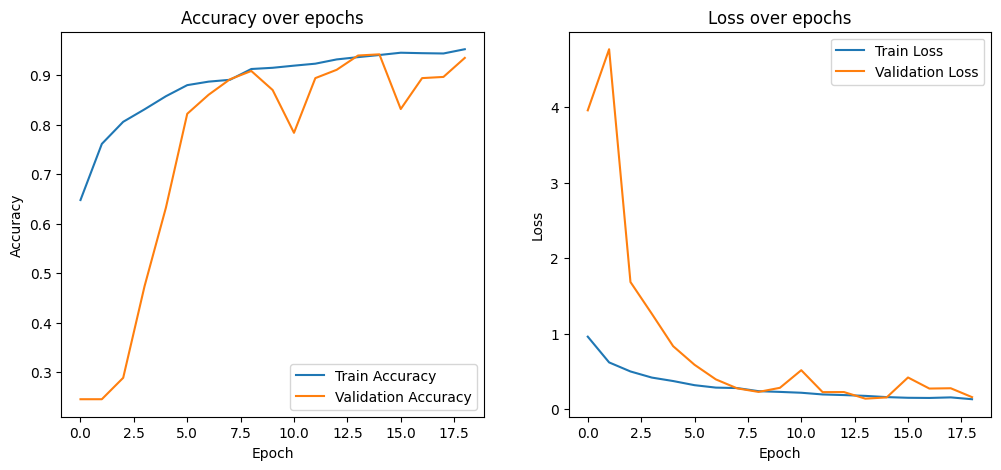

In [9]:
plot_history(history)

### Model evaluation

13/13 [==============================] - 1s 38ms/step - loss: 0.1477 - accuracy: 0.9580
              precision    recall  f1-score   support

Early_Blight       0.99      0.96      0.97       162
     Healthy       0.95      0.92      0.94       102
 Late_Blight       0.93      0.99      0.96       141

    accuracy                           0.96       405
   macro avg       0.96      0.95      0.96       405
weighted avg       0.96      0.96      0.96       405



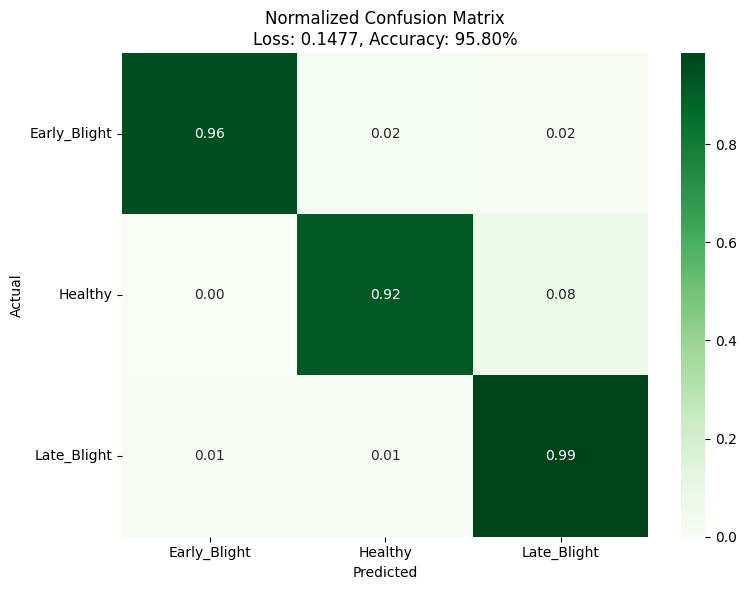

In [10]:
evaluate(test_set, model)

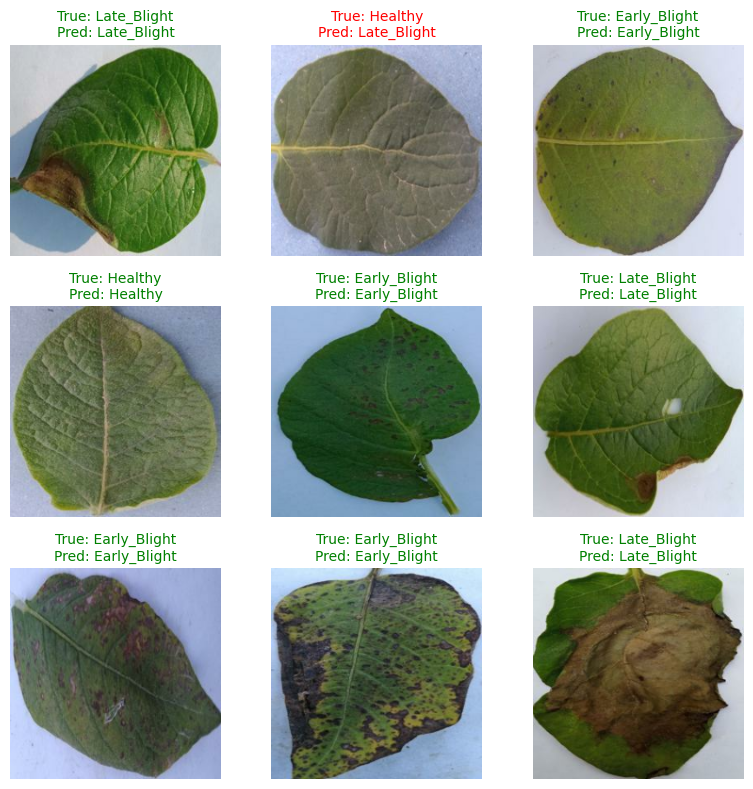

In [11]:
show_predictions(model, test_set)

## `2` Using a pretrained model `ResNet50V2`

### Model building

In [12]:
base_model = ResNet50V2(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable = False
    
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    layers.Rescaling(1./255),

    base_model,

    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                      

### Model training

In [13]:
np.random.seed(SEED)
tf.random.set_seed(SEED)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(train_set,validation_data=val_set,epochs=50, callbacks=[early_stop])

Epoch 1/50
102/102 [==============================] - 15s 117ms/step - loss: 0.3874 - accuracy: 0.8499 - val_loss: 0.4234 - val_accuracy: 0.8077
Epoch 2/50
102/102 [==============================] - 11s 104ms/step - loss: 0.2517 - accuracy: 0.9068 - val_loss: 0.2793 - val_accuracy: 0.8798
Epoch 3/50
102/102 [==============================] - 11s 104ms/step - loss: 0.1970 - accuracy: 0.9268 - val_loss: 0.2479 - val_accuracy: 0.8966
Epoch 4/50
102/102 [==============================] - 11s 104ms/step - loss: 0.1852 - accuracy: 0.9299 - val_loss: 0.2093 - val_accuracy: 0.9207
Epoch 5/50
102/102 [==============================] - 11s 103ms/step - loss: 0.1569 - accuracy: 0.9388 - val_loss: 0.2643 - val_accuracy: 0.8990
Epoch 6/50
102/102 [==============================] - 11s 103ms/step - loss: 0.1621 - accuracy: 0.9382 - val_loss: 0.3322 - val_accuracy: 0.8846
Epoch 7/50
102/102 [==============================] - 11s 105ms/step - loss: 0.1516 - accuracy: 0.9440 - val_loss: 0.1677 - val_ac

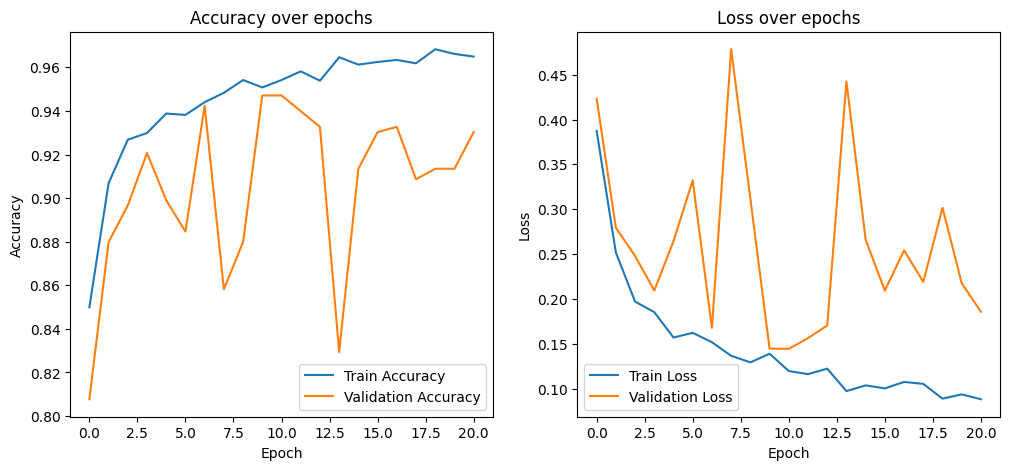

In [14]:
plot_history(history)

### Model Evaluation

13/13 [==============================] - 2s 131ms/step - loss: 0.1806 - accuracy: 0.9333
              precision    recall  f1-score   support

Early_Blight       0.96      0.93      0.94       162
     Healthy       0.91      0.94      0.92       102
 Late_Blight       0.93      0.93      0.93       141

    accuracy                           0.93       405
   macro avg       0.93      0.93      0.93       405
weighted avg       0.93      0.93      0.93       405



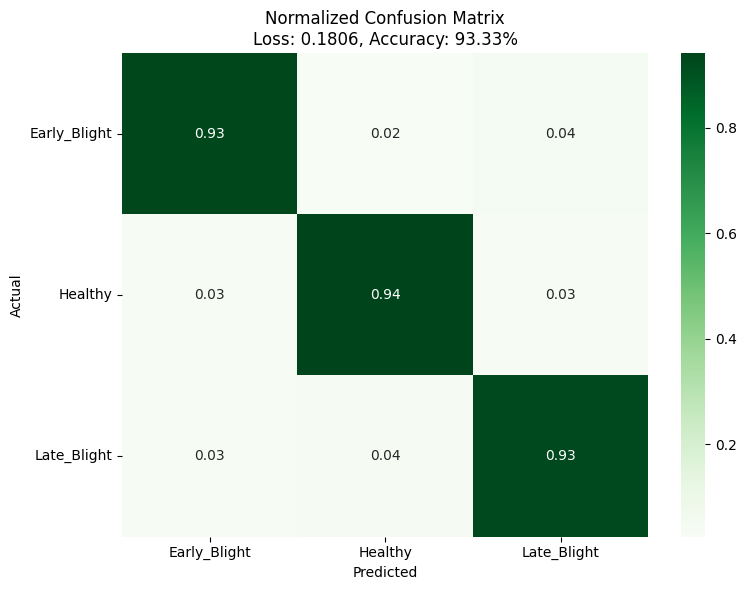

In [15]:
evaluate(test_set, model)

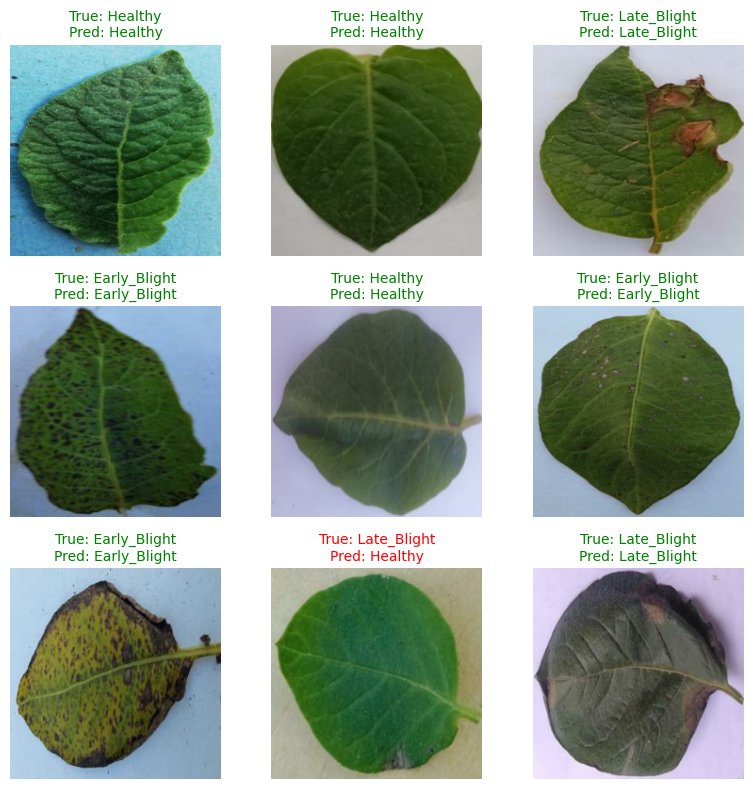

In [16]:
show_predictions(model, test_set)